# 야놀자 숙소 리뷰 요약을 위한 GPT 모델 만들기
- 리뷰 요약을 위한 모델을 GPT-3.5로 만들고 GPT-4의 성능을 넘을 수 있게 고도하 시키기

## 1. API Key 및 기본 설정

In [1]:
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from openai import OpenAI
from getpass import getpass

In [3]:
MY_API_KEY = getpass.getpass("OpenAI API key : ")

OpenAI API key :  ········


In [5]:
client = OpenAI(api_key=MY_API_KEY)

## 데이터 전처리
- 프롬프트 입력 및 모델 평가를 위해 JSON 형태의 파일에서 리뷰를 구분할 수 있게 문자열로 만들어주기

### 1) 수집한 리뷰 JSON 파일 로드
- 야놀자 홈페이지에서 '신라스테이 역삼'호텔에 대한 리뷰를 20 스크롤 정도 크롤링한 데이터

In [9]:
with open("data/ya_review_sinla.json", "r", encoding="utf-8") as f:
    # json.load: JSON 파일 불러오기
    review_list = json.load(f)
print(len(review_list))
review_list[:10]

420


[{'review': '고민하다가 조식포함으로 결정했는데 좋은 선택이었습니다. 같이간 이들도 만족스러워했어요. 조식도 좋았고 시설, 서비스, 청결도 나무랄데가 없었네요.',
  'stars': 5,
  'date': '2024.06.03'},
 {'review': '커피쿠폰도 받았구 깨끗하고 교회뷰도 이뻤어요!!!', 'stars': 5, 'date': '2022.11.20'},
 {'review': '잊을수없는 추억을 남겼어요 너무너무 좋았어요\r\n여자친구 몰래 프로포즈를 준비하게되었는데\r\n프론트 체크인 도와주셨던 직원분께 양해를 구하고\r\n선물을 미리 맡겨주셨고 프로포즈셋팅까지 완벽하게 진행될 수 있도록 정말 많은 도움 주셨어요\r\n바쁘신 와중에도 제가 계획한대로 체크인도 도와주셨고 딜라이브 ott까지 챙겨주시는 섬세함에 감동받았습니다 나중에 기념일때 다시한번 꼭 방문하겠습니다 성함을 기억했어야 하는데 젊은 남직원분\r\n다음번 방문때 감사인사 드리겠습니다\r\n훌륭한 룸컨디션도 칭찬합니다',
  'stars': 5,
  'date': '2022.10.17'},
 {'review': '조식이 맛있어요!!다양하게 종류도 많구요 캠페인중이여서 할인도 해서 먹었는데 맛있습니다\n직원분들 친절하고 대응도 잘해주세요',
  'stars': 5,
  'date': '1일 전'},
 {'review': '가족들이 간다고 해서 진짜 폭풍 검색해서 알아봐드렸는데 좋아하셔서 좋았습니다 :) 신라스테이는 어딜 가도 좋은것 같아요',
  'stars': 5,
  'date': '3일 전'},
 {'review': '프론트 직원분들이 친절하셔서 좋아요', 'stars': 5, 'date': '3일 전'},
 {'review': '아주좋아요오오옹오ㅗ옹', 'stars': 5, 'date': '2024.10.08'},
 {'review': '청결하고 좋습니다 특히 조식이 맛있었어요', 'stars': 5, 'date': '2024.10.08'},
 {'review': '깨끗

### 2) 높은 평점 기준 정의(야놀자 리뷰 요약 중에 높은 평점 요약만 사용)
전체 평점이 4.7점이므로 높은 평점은 5점으로 정의
- 높은 평점: 별 5개 
- 낮은 평점: 별 4개 이하

In [12]:
# 리스트 내부의 딕셔너리 key값(star)로 value(실제 점수)추출 수 빈 리스트에 넣기
star_list = [i['stars'] for i in review_list]

In [14]:
np.mean(star_list)

4.754761904761905

<Axes: ylabel='count'>

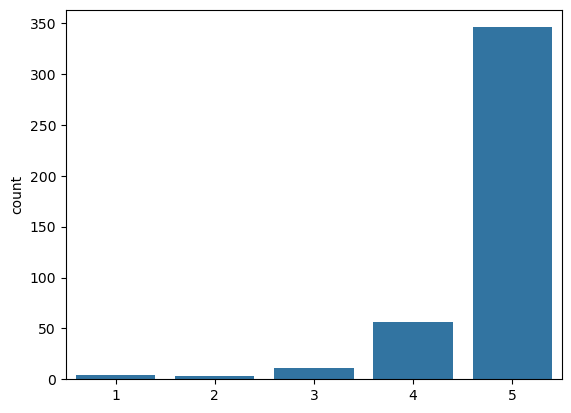

In [16]:
sns.countplot(x = star_list)

### 3) 높은 평점 리뷰 저장

In [19]:
reviews_high = []
for i in review_list:
    if i['stars'] == 5:
        # LLM 학습에 사용되고 있는 스페션 토큰(START, END) 형식으로 한 리뷰의 시작과 끝은 구분하여
        # 모델이 더 잘 이해할 수 있도록 설정
        reviews_high.append('[REVIEW_START]' + i['review'] + '[REVIEW_END]')

print(reviews_high[:5])

['[REVIEW_START]고민하다가 조식포함으로 결정했는데 좋은 선택이었습니다. 같이간 이들도 만족스러워했어요. 조식도 좋았고 시설, 서비스, 청결도 나무랄데가 없었네요.[REVIEW_END]', '[REVIEW_START]커피쿠폰도 받았구 깨끗하고 교회뷰도 이뻤어요!!![REVIEW_END]', '[REVIEW_START]잊을수없는 추억을 남겼어요 너무너무 좋았어요\r\n여자친구 몰래 프로포즈를 준비하게되었는데\r\n프론트 체크인 도와주셨던 직원분께 양해를 구하고\r\n선물을 미리 맡겨주셨고 프로포즈셋팅까지 완벽하게 진행될 수 있도록 정말 많은 도움 주셨어요\r\n바쁘신 와중에도 제가 계획한대로 체크인도 도와주셨고 딜라이브 ott까지 챙겨주시는 섬세함에 감동받았습니다 나중에 기념일때 다시한번 꼭 방문하겠습니다 성함을 기억했어야 하는데 젊은 남직원분\r\n다음번 방문때 감사인사 드리겠습니다\r\n훌륭한 룸컨디션도 칭찬합니다[REVIEW_END]', '[REVIEW_START]조식이 맛있어요!!다양하게 종류도 많구요 캠페인중이여서 할인도 해서 먹었는데 맛있습니다\n직원분들 친절하고 대응도 잘해주세요[REVIEW_END]', '[REVIEW_START]가족들이 간다고 해서 진짜 폭풍 검색해서 알아봐드렸는데 좋아하셔서 좋았습니다 :) 신라스테이는 어딜 가도 좋은것 같아요[REVIEW_END]']


In [21]:
# 리스트로 나오는데 prompt에 넣으려면 문자열로 넣어야해서 join함수로 문자열로 합치기
reviews_high_text = '\n'.join(reviews_high)
print(reviews_high_text[:500])

[REVIEW_START]고민하다가 조식포함으로 결정했는데 좋은 선택이었습니다. 같이간 이들도 만족스러워했어요. 조식도 좋았고 시설, 서비스, 청결도 나무랄데가 없었네요.[REVIEW_END]
[REVIEW_START]커피쿠폰도 받았구 깨끗하고 교회뷰도 이뻤어요!!![REVIEW_END]
[REVIEW_START]잊을수없는 추억을 남겼어요 너무너무 좋았어요
여자친구 몰래 프로포즈를 준비하게되었는데
프론트 체크인 도와주셨던 직원분께 양해를 구하고
선물을 미리 맡겨주셨고 프로포즈셋팅까지 완벽하게 진행될 수 있도록 정말 많은 도움 주셨어요
바쁘신 와중에도 제가 계획한대로 체크인도 도와주셨고 딜라이브 ott까지 챙겨주시는 섬세함에 감동받았습니다 나중에 기념일때 다시한번 꼭 방문하겠습니다 성함을 기억했어야 하는데 젊은 남직원분
다음번 방문때 감사인사 드리겠습니다
훌륭한 룸컨디션도 칭찬합니다[REVIEW_END]
[REVIEW_START]조식이 맛있어요!!다양하게 종류도 많구요 캠페


## 4) 리뷰의 기간을 6개월로 설정하고 모든 전처리 단계를 함수화 시켜두기
- 야놀자 홈페이지에서 요약한 후기는 최근 6개얼간의 후기로 요약한 결과
- 우리 데이터는 24년 10월 16일에 수집된 데이터로 그 날 이전의 데이터들을 포함하고 있음.
- so, 그 날부터 이전 6개월간의 동일한 기간의 데이터를 추출

In [24]:
import datetime
# dateutil: 다양한 형식의 날짜와 시간 문자열을 파싱하고 처리할 수 있는 모듈
# parser: 문자열에서 날짜와 시간 정보를 자동으로 인식하여 코드로 파싱하는 함수

from dateutil import parser

In [26]:
# 리뷰 데이터 전처리 함수 만들기
def preprocess_reviews(path = "data/ya_review_sinla.json"):
    with open(path, "r", encoding="utf-8") as f:
        review_list = json.load(f)
    reviews_high = []
    # 기간 및 날짜 처리
    base_date = datetime.datetime(2024, 10, 16)
    
    # timedelta: 날짜 또는 시간 간의 차이를 구해주는 함수
    # 매개변수는 weeks, days, hours, minutes, seconds
    # base_date에서 최근 6개월(24주)간의 데이터의 기준 날짜를 설정
    date_boundary = base_date - datetime.timedelta(weeks=24)

    for i in review_list:
        # 각 리뷰의 날짜를 문자열로 변수에 저장
        review_date_str = i['date']
        try:
            # parser: 문자열을 날짜 타입으로 변경시켜주는 함수
            review_date = parser.parse(review_date_str)
            # 만약 ValueError, TypeError가 발생한다면(년월일로 표시되지 않은 값들은 parse 함수 사용시 에러 발생)
        except (ValueError, TypeError):
            # '~일 전'이라는 리뷰들은 최근 6개월 내에 반드시 포함되기 때문에 그냥 현재 날짜로 변경해도 무방
            review_date = base_date
        # 해당 리뷰의 날짜가 6개월 전 날짜보다 작다면 후속 작업 없이 넘어감.
        if  review_date < date_boundary:
            continue
        if i['stars'] == 5:
            reviews_high.append('[REVIEW_START]' + i['review'] + '[REVIEW_END]')
        reviews_high_text = '\n'.join(reviews_high)
    return reviews_high_text # 모든 전처리가 끝난 리뷰 데이터 문자열 반환

In [28]:
datetime.datetime(2024, 10, 16)

datetime.datetime(2024, 10, 16, 0, 0)

### 3. 리뷰 문장 요약을 위한 Baseline 모델 개발
- base 모델(gpt-3.5)의 요약이 야놀자 후기 요약 문장(gpt-4)에 근접하게 성능을 향상시켜보는 것이 우리의 목표

In [31]:
reviews = preprocess_reviews() # 디폴트 경로는 신라호텔 데이터의 경로

In [33]:
len(reviews)

6916

In [35]:
# 기준이 되는 베이스 프롬프트를 시작으로 점점 고도화 시켜나갈 예정
PROMPT_BASELINE = "아래 숙소 리뷰에 대해 5문장 이내로 요약해주라."

## 1) 리뷰 요약 함수 선언

In [38]:
def summarize(reviews, prompt, temperature = 0, model = 'gpt-3.5-turbo'):
    prompt = prompt + '\n\n' + reviews

    completion = client.chat.completions.create(model = model,
                                                messages = [{'role': 'user','content':prompt}],
                                                temperature = temperature)
    return completion.choices[0].message.content

## 2) 모델별 요약 결과

In [41]:
# base 모델 요약 결과(gpt-3.5-turbo)
print(summarize(reviews, PROMPT_BASELINE))

조식 포함으로 선택한 숙소는 시설, 서비스, 청결도 모두 만족스러웠고, 같이간 이들도 좋아했다. 위치도 좋아서 재방문 의사가 있다.


In [42]:
# 야놀자 홈페이지 높은 평점 휴기 요약 결과(gpt-4-turbo)
summary_gpt4_turbo = """청결하고 쾌적한 환경을 제공하며, 친절한 직원 서비스가 돋보입니다.
조식은 다양한 메뉴와 맛으로 손님들에게 호평을 받으며, 주차 시설도 편리하게 마련되어 있습니다.
객실은 아늑하고 고급스러운 분위기를 연출하며, 일부 객실에서는 도로 소음이 발생할 수 있습니다.
접근성과 주변 식당, 카페가 다양해 이용객의 편의성이 높습니다. 전반적으로 가성비가 우수하고, 재방문 의사가 있는 곳입니다."""
summary_gpt4_turbo

'청결하고 쾌적한 환경을 제공하며, 친절한 직원 서비스가 돋보입니다.\n조식은 다양한 메뉴와 맛으로 손님들에게 호평을 받으며, 주차 시설도 편리하게 마련되어 있습니다.\n객실은 아늑하고 고급스러운 분위기를 연출하며, 일부 객실에서는 도로 소음이 발생할 수 있습니다.\n접근성과 주변 식당, 카페가 다양해 이용객의 편의성이 높습니다. 전반적으로 가성비가 우수하고, 재방문 의사가 있는 곳입니다.'

## 4. 모델 평가 함수 선언
#### 1) 평가 기준 설정
- MT-Bench 논문 기반 PairWise Comparision 방식 사용
  - LLM 기반 응답 품질 비교 평가
  - gpt-4o 모델을 활용하여 2개 모델(gpt-3.5-turbo, gpt-4-turbo)의 요약 결과를 비교, 평가해보자.
#### 2) 평가를 위한 스크립트 및 모델 실행 코드 작성
- 기존 MT-Bench 논문의 평가용 프롬프트에서 우리의 task에 맞게 일부만 수정한 프롬프트 활용

In [46]:
def pairwise_eval(reviews, answer_a, answer_b):
    eval_prompt = f"""[System]
Please act as an impartial judge and evaluate the quality of the Korean summaries provided by two
AI assistants to the set of user reviews on accommodations displayed below. You should choose the assistant that
follows the user's instructions and answers the user's question better. Your evaluation
should consider factors such as the helpfulness, relevance, accuracy, depth, creativity,
and level of detail of their responses. Begin your evaluation by comparing the two
responses and provide a short explanation. Avoid any position biases and ensure that the
order in which the responses were presented does not influence your decision. Do not allow
the length of the responses to influence your evaluation. Do not favor certain names of
the assistants. Be as objective as possible. After providing your explanation, output your
final verdict by strictly following this format: "[[A]]" if assistant A is better, "[[B]]"
if assistant B is better, and "[[C]]" for a tie.
[User Reviews]
{reviews}
[The Start of Assistant A's Answer]
{answer_a}
[The End of Assistant A's Answer]
[The Start of Assistant B's Answer]
{answer_b}
[The End of Assistant B's Answer]"""
    # 평가를 위한 LLM은 gpt-4o 버전으로 지정
    completion = client.chat.completions.create(model = 'gpt-4o',
                                                messages = [{'role':'user','content':eval_prompt}],
                                                temperature = 0)
    return completion.choices[0].message.content

## 3) base 모델(gpt-3.5)과 gpt4모델 하나씩의 응답에 대해 시범 평가

In [49]:
# base모델 응답
answer_a = summarize(reviews, PROMPT_BASELINE)

In [51]:
# 평가 함수 실행
print(pairwise_eval(reviews, answer_a, summary_gpt4_turbo))

Both Assistant A and Assistant B provided summaries of the user reviews for the accommodations. However, there are notable differences in their responses:

1. **Helpfulness and Relevance**: 
   - Assistant A's summary is concise and focuses on the key aspects mentioned in the reviews, such as the quality of breakfast, the satisfaction with the facilities, service, and cleanliness, and the convenience of the location and parking.
   - Assistant B provides a more detailed summary, covering additional aspects such as the ambiance of the rooms, potential noise issues, and the convenience of nearby amenities. This makes Assistant B's response more comprehensive and relevant to the various points mentioned in the reviews.

2. **Accuracy and Depth**:
   - Assistant A accurately captures the positive sentiments about the breakfast, service, and overall satisfaction but lacks depth in covering other aspects mentioned in the reviews.
   - Assistant B accurately reflects the reviews' content and 

## 5. 메인 평가 진행
- 실무에서는 다양한 데이터에 대해 더 많은 횟수로 평가하지만 지금은 그렇게 하기 힘들기 때문에 동일한 prompt에 대해 temperature를 높여서 다양한 응답을 10개 만들어서 비교 평가를 진행
- 경험상 50~100번 정도의 평가를 진행하면 좋지만 시간과 비용의 문제로 일단 10번 정도만 진행

In [54]:
# temperature를 디폴트인 0.8로 설정하고 10번의 용약 결과를 리스트에 담기
summaries_baseline = [summarize(reviews, PROMPT_BASELINE, temperature=0.8) for _ in range(10)]
summaries_baseline

['조식포함으로 결정한 숙소는 시설, 서비스, 청결도 모두 만족스러웠고, 직원들도 친절하고 대응이 빨랐다. 아이와 함께 머물기에도 안전하고 가격 대비 성능이 좋았다. 위치가 조금 아쉬워도 다음에도 재방문 의사가 있다.',
 '조식포함으로 선택한 숙소는 좋은 선택이었고, 조식과 시설, 서비스, 청결도에 대해 만족스러웠다. 같이간 이들도 만족했다.',
 '조식포함으로 선택한 숙소는 시설, 서비스, 청결도 모두 만족스러웠고, 조식도 맛있다는 리뷰가 많았다. 직원들의 친절도도 양호하며, 가격대비 만족스러운 숙박이었다.',
 '조식 포함으로 선택한 숙소는 조식이 맛있고 시설, 서비스, 청결도 모두 좋았다. 같이 간 이들도 만족해했으며, 직원들도 친절했다. 위치가 편리하고 가족들이 좋아하는 숙소로 추천된다. 프론트 직원들도 친절하며, 깨끗하고 조용한 환경에서 편안한 휴식을 즐길 수 있다.',
 '조식포함으로 선택한 숙소는 즐거운 선택이었고, 시설, 서비스, 청결도 모두 만족스러웠다. 같이간 이들도 만족했으며 직원분들의 친절한 대응도 좋았다.',
 '조식 포함으로 선택한 숙소는 시설, 서비스, 청결도 모두 만족스러웠다. 함께 간 이들도 좋아했다.',
 '다양한 리뷰들을 종합하면, 조식이 맛있고 시설이 깔끔하며 직원들이 친절한 신라스테이에서 편안한 휴식을 즐길 수 있다.',
 '조식 포함으로 선택한 숙소는 시설, 서비스, 청결도 모두 만족스러웠고, 같이간 이들도 좋아했다. 혜택 중인 할인과 맛있는 조식도 좋았고, 직원들의 친절한 대응이 더욱 만족스러웠다. 추천할 만한 신라스테이 숙소였다.',
 '조식 포함으로 선택한 숙소는 시설, 서비스, 청결도 모두 좋았고, 같이간 이들도 만족했다. 조식이 다양하고 맛있으며, 직원들도 친절하고 대응도 잘해줬다. 가족들이 만족했고, 프론트 직원도 친절했다. 전체적으로 청결하고 조식이 맛있어서 만족스러웠다. 위치가 좋고 주차 편리하며, 룸 컨디션도 좋았다.',
 '조식포함으로 결정한 숙소는 시설, 서비스, 청결도 모두 좋았고, 가족들도 만족한

In [56]:
len(summaries_baseline)

10

In [58]:
# gpt-4모델도 비교를 우해 10번을 리스트에 넣기
summaries_gpt4 = [summary_gpt4_turbo for _ in range(10)]
len(summaries_gpt4)

10

# 10번씩 평가함수 설정(gpt3.5가 gpt4에 비해 얼마나 승리했는지 출력)
def pairwise_eval_batch(reviews, answers_a, answers_b):
    a_cnt, b_cnt, c_cnt = 0,0,0 # 승리, 패배, 무승부
    for i in tqdm(range(10)):
        result_text = pairwise_eval(reviews, answers_a[i], answers_b[i])
        
        # 평가 함수로 평가한 응답 중에 [[A]]가 있다면 = gpt3.5가 더 요약을 잘했다면
        if '[[A]]' in result_text:
            a_cnt += 1
        # gpt4가 요약을 더 잘했다면
        elif '[[B]]' in result_text:
            b_cnt += 1
        # 둘 다 요약 성능이 동일하다면
        elif '[[C]]' in result_text:
            c_cnt += 1
        else:
            print('Error occurred!')
    return a_cnt, b_cnt, c_cnt

In [62]:
wins, losses, ties = pairwise_eval_batch(reviews, summaries_baseline, summaries_gpt4)
print(f'Wins: {wins}, Losses: {losses}, Ties: {ties}')

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:51<00:00,  5.15s/it]

Wins: 0, Losses: 10, Ties: 0


### 10번 다 짐ㅋㅋ큐ㅠㅠ 실화냐

## 6. 모델 및 프롬프트 고도화
1) 프롬프트 엔지니어링(페르소나 및 조건 명시)

In [66]:
prompt = """
당신은 문장 요약 전문가입니다. 사용자 숙소 리뷰들이 주어졌을 때 이를 요약하는 것이 당신의 임무입니다.

요약 결과는 다음 조건들을 충족해야합니다.
1. 모든 문장은 항상 존댓말을 사용합니다.
2. 숙소에 대해 소개하는 톤앤매너로 작성합니다.
    2-1. 좋은 리뷰 요약 예시
        a)  전반적으로 좋은 숙소였고 방음도 괜찮았다는 평입니다.
        b)  재방문 예정이라는 평들이 존재합니다.
    2-2. 나쁜 리뷰 요약 예시
        a) 좋은 숙소였고 방음도 괜찮음.
        b) 재방문 예정
3. 요약 결과는 최소 4문장 이상 최대 7문장 이내로 작성합니다.

아래 숙소 리뷰들에 대해 요약해주세요.
"""
# 변경된 프롬프트를 넣어서 10번 요약 실행
summaries_optil1 = [summarize(reviews, prompt, temperature=0.8) for _ in range(10)]

In [70]:
# 1차 튜닝한 프롬프트로 요약한 결과와 기존 gpt-4-turbo 모델의 결과를 10회 비교
wins, losses, ties = pairwise_eval_batch(reviews, summaries_optil1, summaries_gpt4)
print(f'Wins: {wins}, Losses: {losses}, Ties: {ties}')

100%|█████████████████████████████████████████████████| 10/10 [01:06<00:00,  6.61s/it]

Wins: 9, Losses: 1, Ties: 0


### 2) 입력데이터의 품질 향상시키기
- 실제 숙소에 대한 정보가 포함되지 않는 단순하고 짧은 리뷰들은 필터링하기 ex) 좋았어요, 굳굳 등
- 우리가 해결하고자 하는 문제에 따라서 입력데이터의 품질에 대한 기준은 달라질 수 있음.

In [79]:
# 짧은 리뷰 데이터들을 필터링할 수 있는 전처리 함수
def preprocess_reviews(path = "data/ya_review_sinla.json"):
    with open(path, "r", encoding="utf-8") as f:
        review_list = json.load(f)
    reviews_high = []
    base_date = datetime.datetime(2024, 10, 16)

    date_boundary = base_date - datetime.timedelta(weeks=24)
    
    filtered_cnt = 0 # 필터링 된 리뷰 개수 카운트용
    
    for i in review_list:
        review_date_str = i['date']
        try:
            review_date = parser.parse(review_date_str)
        except (ValueError, TypeError):
            review_date = base_date
        if  review_date < date_boundary:
            continue
            
        # 리뷰의 길이가 15자 미만이면 다시 되돌아가게 설정
        if len(i['review']) < 15:
            filtered_cnt += 1
            continue
            
        
        if i['stars'] == 5:
            reviews_high.append('[REVIEW_START]' + i['review'] + '[REVIEW_END]')
            
    # 사용할 리뷰 개수를 최대 50개까지만 지정(gpt-3.5모델의 경우 토큰수의 제한이 크지 않아서 입력이 너무 길면 에러가 발생)
    # min함수를 사용해서 10자 이상인 리뷰들의 개수가 50개보다 적다면 해당 개수만큼만 사용하고 더 많아도 50개까지만 사용하도록 지정
    reviews_high = reviews_high[ : min(len(reviews_high), 50)]
    print("Number of reviews with less than 10 letters: ", filtered_cnt)
    print("Number of reviews with high ratings after filtering: ", len(reviews_high))
    reviews_high_text = '\n'.join(reviews_high)
    return reviews_high_text

In [81]:
# 변경된 전처리 함수를 리뷰데이터에 다시 적용
reviews = preprocess_reviews()

Number of reviews with less than 10 letters:  42
Number of reviews with high ratings after filtering:  50


In [83]:
# 프롬프팅 + 데이터 필터링이 적용된 요약 결과
summaries_opti2 = [summarize(reviews, prompt, temperature=0.8) for _ in range(10)]

In [87]:
# 1차 튜닝한 프롬프트로 요약한 결과와 기존 gpt-4-turbo 모델의 결과를 10회 비교
wins, losses, ties = pairwise_eval_batch(reviews, summaries_opti2, summaries_gpt4)
print(f'Wins: {wins}, Losses: {losses}, Ties: {ties}')

100%|█████████████████████████████████████████████████| 10/10 [00:57<00:00,  5.79s/it]

Wins: 8, Losses: 2, Ties: 0


### 입력데이터의 품질을 올려주는 것만으로도 조금 더 성능의 향상을 볼 수 있다는데 왜 더 성능이 떨어졌냐....

### 3) Few-shot learning
- 질의-응답 쌍의 예시를 들어주기 위해 새로운 숙소의 리뷰와 그 요약을 예시로 넣어주기

In [94]:
# one-shot
# 요약 예시문으로 활용하기 위한 글래드 강남 코엑스센터 호텔의 리뷰를 불러와서 전처리 진행
reviews_1shot = preprocess_reviews('data/ya_review_glad.json')

# 요약 예시문 생성(좀 더 좋은 예시를 위해 상급 모델 활용)
summarize_1shot = summarize(reviews_1shot, prompt, temperature=0, model='gpt-4o')
summarize_1shot

Number of reviews with less than 10 letters:  56
Number of reviews with high ratings after filtering:  50


'전반적으로 글래드 삼성 호텔은 편리한 위치와 청결한 시설로 많은 고객들에게 좋은 평가를 받고 있습니다. 삼성역과 가까워 교통이 편리하며, 코엑스와 인접해 있어 다양한 부대시설을 쉽게 이용할 수 있는 장점이 있습니다. 침구의 편안함과 직원들의 친절한 서비스는 고객들에게 큰 만족을 주고 있으며, 특히 얼리 체크인과 같은 유연한 서비스가 긍정적인 반응을 얻고 있습니다. 다만, 일부 고객들은 소음 문제와 뷰에 대한 아쉬움을 표현하기도 했습니다. 전반적으로 가성비가 좋고, 재방문 의사를 밝히는 고객들이 많아 추천할 만한 숙소입니다.'

In [100]:
prompt_1shot = f"""
당신은 문장 요약 전문가입니다. 사용자 숙소 리뷰들이 주어졌을 때 이를 요약하는 것이 당신의 임무입니다.

요약 결과는 다음 조건들을 충족해야합니다.
1. 모든 문장은 항상 존댓말을 사용합니다.
2. 숙소에 대해 소개하는 톤앤매너로 작성합니다.
    2-1. 좋은 리뷰 요약 예시
        a)  전반적으로 좋은 숙소였고 방음도 괜찮았다는 평입니다.
        b)  재방문 예정이라는 평들이 존재합니다.
    2-2. 나쁜 리뷰 요약 예시
        a) 좋은 숙소였고 방음도 괜찮음.
        b) 재방문 예정
3. 요약 결과는 최소 4문장 이상 최대 7문장 이내로 작성합니다.

다음 참고할 리뷰들과 그에 대한 요약 예시입니다.
[예시 리뷰들]: {reviews_1shot}
[예시 요약 결과]: {summarize_1shot}

아래 숙소 리뷰들에 대해 요약해주세요.
"""
# 변경된 프롬프트를 넣어서 10번 요약 실행
summaries_opti3 = [summarize(reviews, prompt_1shot, temperature=0.8) for _ in range(10)]

In [102]:
# 튜닝한 프롬프트로 요약한 결과와 기존 gpt-4-turbo 모델의 결과를 10회 비교
wins, losses, ties = pairwise_eval_batch(reviews, summaries_opti3, summaries_gpt4)
print(f'Wins: {wins}, Losses: {losses}, Ties: {ties}')

100%|█████████████████████████████████████████████████| 10/10 [01:17<00:00,  7.74s/it]

Wins: 8, Losses: 2, Ties: 0


### 성능이 그대로세요;;;;;;;
- few-shot learning을 한다고 해서 무조건 성능이 좋아지는 건 아님.
- prompt-engineering은 무한 테스트의 영역ㅠㅠㅠ

### 프롬프트 조건을 바꿔보자.

In [106]:
prompt_1shot_v2 = f"""
당신은 문장 요약 전문가입니다. 사용자 숙소 리뷰들이 주어졌을 때 이를 요약하는 것이 당신의 임무입니다.

요약 결과는 최소 4문장 이상 최대 7문장 이내로 작성합니다.

다음 참고할 리뷰들과 그에 대한 요약 예시입니다.
[예시 리뷰들]: {reviews_1shot}
[예시 요약 결과]: {summarize_1shot}

아래 숙소 리뷰들에 대해 요약해주세요.
"""
# 변경된 프롬프트를 넣어서 10번 요약 실행
summaries_opti4 = [summarize(reviews, prompt_1shot_v2, temperature=0.8) for _ in range(10)]

In [108]:
# 튜닝한 프롬프트로 요약한 결과와 기존 gpt-4-turbo 모델의 결과를 10회 비교
wins, losses, ties = pairwise_eval_batch(reviews, summaries_opti4, summaries_gpt4)
print(f'Wins: {wins}, Losses: {losses}, Ties: {ties}')

100%|█████████████████████████████████████████████████| 10/10 [00:52<00:00,  5.21s/it]

Wins: 7, Losses: 3, Ties: 0


### Two-shot learning으로 더 많은 예시를 줘보자.
1. 호텔 인 나인 리뷰 파일 로드 후 전처리
2. 요약 결과 출력(temperatur = 0, model = 'gpt-4o')
3. 호텔 인 나인 리뷰와 요약 결과를 새로운 프롬프트에 넣어서 two-shot으로 구성(변수명: prompt_2shot)
4. 10번의 반복 요약(변수명: summaries_opti5)
5. 최종 평가

In [116]:
# 1,2 번
reviews_2shot = preprocess_reviews('data/ya_review_in9.json')
summary_2shot = summarize(reviews_2shot, prompt_1shot_v2, temperature=0, model = 'gpt-4o')
summary_2shot

Number of reviews with less than 10 letters:  42
Number of reviews with high ratings after filtering:  46


'이 숙소는 코엑스와의 접근성이 뛰어나고, 봉은사역과도 가까워 교통이 매우 편리하다는 점에서 많은 고객들에게 좋은 평가를 받고 있습니다. 객실은 청결하고 침구가 편안하여 숙박의 질을 높여주며, 특히 침대의 편안함에 대한 긍정적인 리뷰가 많습니다. 직원들의 친절한 서비스와 발렛 주차 서비스도 고객 만족도를 높이는 요소로 작용하고 있습니다. 다만, 일부 고객들은 도로 소음과 에어컨 온도 조절 문제를 지적하며 개선이 필요하다고 언급했습니다. 전반적으로 위치, 청결, 서비스 면에서 높은 평가를 받고 있으며, 재방문 의사를 밝히는 고객들이 많아 추천할 만한 숙소입니다.'

In [120]:
# 3,4 번
prompt_2shot = f"""
당신은 문장 요약 전문가입니다. 사용자 숙소 리뷰들이 주어졌을 때 이를 요약하는 것이 당신의 임무입니다.

요약 결과는 최소 4문장 이상 최대 7문장 이내로 작성합니다.

다음 참고할 리뷰들과 그에 대한 요약 예시입니다.
[예시 리뷰들1]: {reviews_1shot}
[예시 요약 결과1]: {summarize_1shot}

[예시 리뷰들2]: {summary_2shot}
[예시 요약 결과2]: {summary_2shot}

아래 숙소 리뷰들에 대해 요약해주세요.
"""
# 변경된 프롬프트를 넣어서 10번 요약 실행
summaries_opti5 = [summarize(reviews, prompt_2shot, temperature=0.8) for _ in range(10)]

In [122]:
# 튜닝한 프롬프트로 요약한 결과와 기존 gpt-4-turbo 모델의 결과를 10회 비교
wins, losses, ties = pairwise_eval_batch(reviews, summaries_opti5, summaries_gpt4)
print(f'Wins: {wins}, Losses: {losses}, Ties: {ties}')

100%|█████████████████████████████████████████████████| 10/10 [00:48<00:00,  4.87s/it]

Wins: 9, Losses: 1, Ties: 0


### 우와 성능이 개 쪼꼼 좋아짐!!!

### 자유롭게 프롬프트 및 데이터 전처리를 변경해서 성능을 높여보자.
- 평가 횟수는 20번으로 상향(3.5-turbo, 4-turbo 모두 20개씩 요약하고 평가도 20번으로 상향)
- ChatGPT나 외부 소프트웨어 도움 없이 직접 프롬프트 및 데이터를 변경할 것
- 가장 Wins가 높을 때의 결과 및 코드 캡쳐

In [126]:
summaries_gpt4_20 = [summary_gpt4_turbo for _ in range(20)]

In [149]:
prompt_2shot = f"""
당신은 문장 요약 전문가입니다. 사용자 숙소 리뷰들이 주어졌을 때 이를 요약하는 것이 당신의 임무입니다.

요약 결과는 최소 4문장 이상 최대 7문장 이내로 작성합니다.

다음 참고할 리뷰들과 그에 대한 요약 예시입니다.
[예시 리뷰들1]: {reviews_1shot}
[예시 요약 결과1]: {summarize_1shot}

[예시 리뷰들2]: {summary_2shot}
[예시 요약 결과2]: {summary_2shot}

예시 리뷰들과 예시 요약 결과들을 참고하여 비슷하게 아래 숙소 리뷰들에 대해 요약해주세요.
"""
# 변경된 프롬프트를 넣어서 20번 요약 실행
summaries_opti5 = [summarize(reviews, prompt_2shot, temperature=0.8) for _ in range(20)]

In [134]:
# 20번씩 평가함수 설정(gpt3.5가 gpt4에 비해 얼마나 승리했는지 출력)
def pairwise_eval_batch_20(reviews, answers_a, answers_b):
    a_cnt, b_cnt, c_cnt = 0,0,0 # 승리, 패배, 무승부
    for i in tqdm(range(20)):
        result_text = pairwise_eval(reviews, answers_a[i], answers_b[i])
        
        # 평가 함수로 평가한 응답 중에 [[A]]가 있다면 = gpt3.5가 더 요약을 잘했다면
        if '[[A]]' in result_text:
            a_cnt += 1
        # gpt4가 요약을 더 잘했다면
        elif '[[B]]' in result_text:
            b_cnt += 1
        # 둘 다 요약 성능이 동일하다면
        elif '[[C]]' in result_text:
            c_cnt += 1
        else:
            print('Error occurred!')
    return a_cnt, b_cnt, c_cnt

In [136]:
# 튜닝한 프롬프트로 요약한 결과와 기존 gpt-4-turbo 모델의 결과를 20회 비교
wins, losses, ties = pairwise_eval_batch_20(reviews, summaries_opti5, summaries_gpt4_20)
print(f'Wins: {wins}, Losses: {losses}, Ties: {ties}')

100%|█████████████████████████████████████████████████| 20/20 [01:36<00:00,  4.83s/it]

Wins: 16, Losses: 4, Ties: 0


##### 그냥 20번으로 돌렸을때 win:16